# test_ContactVolumes, modified from [hydroelastic_contact_nonconvex_mesh.ipynb](./hydroelastic_contact_nonconvex_mesh.ipynb)
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

If you are not familiar with Drake's hydroelastic contact, study [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb). You can also find more information in Hydroelastic Contact User Guide [here.](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

## Introduction

This tutorial shows you how to set up simulations using compliant-hydroelastic nonconvex meshes. We'll use a simple example of a bell pepper dropped onto a bowl on a table top, with all three objects represented by compliant-hydroelastic meshes. Contact forces are calculated and visualized.

In [1]:
import numpy as np
import os
from pathlib import Path
from IPython.display import Code

from pydrake.geometry import (
    ConvertVolumeToSurfaceMesh, Rgba, Sphere, StartMeshcat,
    SurfaceTriangle, TriangleSurfaceMesh,
    _MakeTriangleFromPolygonMesh, _MakeTriangleFromPolygonMeshWithCentroids)
from pydrake.math import RigidTransform
from pydrake.multibody.meshcat import ContactVisualizer, ContactVisualizerParams
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody.plant import AddMultibodyPlant, MultibodyPlantConfig
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ApplyVisualizationConfig, ModelVisualizer, VisualizationConfig

## Start MeshCat

See the section [Viewing models](./authoring_multibody_simulation.ipynb#Viewing-models) in the tutorial [Authoring a Multibody Simulation](./authoring_multibody_simulation.ipynb) for an introduction to MeshCat.

In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Create compliant-hydroelastic bell pepper, bowl, and table top

In [3]:
bell_pepper_url = "package://drake_models/veggies/yellow_bell_pepper_no_stem_low.sdf"
bell_pepper_str = Path(PackageMap().ResolveUrl(bell_pepper_url)).read_text(encoding="utf-8")
bowl_url = "package://drake_models/dishes/evo_bowl_compliant.urdf"
bowl_str = Path(PackageMap().ResolveUrl(bowl_url)).read_text(encoding="utf-8")
table_top_url = "package://drake_models/dishes/table_top.urdf"
table_top_str = Path(PackageMap().ResolveUrl(table_top_url)).read_text(encoding="utf-8")

### Deactivate test mode

In [4]:
test_mode = False
if test_mode:
    bowl_str = bowl_str.replace("evo_bowl_fine44k.vtk", 
                                "evo_bowl_coarse3k.vtk")

## Create Diagram of the scene and set up visualization

The function `add_scene()` below will create a scene using the assets that we created. It will use `Parser` to add the URDF and SDFormat strings into the scene.

The function `add_viz()` below will create visualization. First we will call `ApplyVisualizationConfig()` to visualize our assets. At this step we will set `publish_contacts=False`, so we can customize contact visualization afterwards. 

To visualize contact result, we will add `ContactVisualizer` with `newtons_per_meter= 20` and `newtons_meters_per_meter= 0.1`. It will draw a red arrow of length 1 meter for each force of 20 newtons and a blue arrow of length 1 meter for each torque of 0.1 newton\*meters. The next section will run the simulation.

In [5]:
def add_scene(time_step):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlant(
        MultibodyPlantConfig(
            time_step=time_step,
            discrete_contact_approximation="lagged"),
        builder)
    parser = Parser(plant)

    # Load the assets that we created.
    parser.AddModels(url=bell_pepper_url)
    parser.AddModels(file_contents=bowl_str, file_type="urdf")
    parser.AddModels(url=table_top_url)

    # Weld the table top to the world so that it's fixed during simulation.
    # The top surface passes the world's origin.
    plant.WeldFrames(plant.world_frame(), 
                     plant.GetFrameByName("top_surface"))

    # Finalize the plant after loading the scene.
    plant.Finalize()

    # Place the bowl on top of the table.
    X_WB = RigidTransform(p=[0, 0, 0.03])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("bowl"), X_WB)
    
    # Drop the bell pepper from above the rim of the bowl. 
    X_WC = RigidTransform(p=[-0.06, 0, 0.30])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("yellow_bell_pepper_no_stem"), X_WC)

    return builder, plant

def add_viz(builder, plant):
    ApplyVisualizationConfig(
        builder=builder, meshcat=meshcat,
        config=VisualizationConfig(
                 default_proximity_color=Rgba(r=0.8, g=0.8, b=0.8, a=0.5),
                 publish_contacts=False))    
    ContactVisualizer.AddToBuilder(
        builder=builder, plant=plant, meshcat=meshcat,
        params=ContactVisualizerParams(
                 newtons_per_meter=20,
                 newton_meters_per_meter= 0.1))

## Run simulation

We will run the simulation. In MeshCat, the red arrow will represent the force `f`, and the blue arrow will represent the torque `tau`. You should see the contact patch moving around together with the force and torque vectors.

After running the code below, playback with `timeScale` = 0.1 to appreciate the contact dynamics. You should see the force and torque vectors oscillate synchronously with the rocking bell pepper and bowl. See the section *Playback recording of the simulation* in [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb) for more details.

Currently playing back the simulation will show contact force and torque correctly; however, it does not show contact patch appropriately, which could be confusing. Issue [19142](https://github.com/RobotLocomotion/drake/issues/19142) explains the problem in more details.

In [6]:
# Clear MeshCat window from the previous blocks.
meshcat.Delete()
meshcat.DeleteAddedControls()

time_step = 1e-2
builder, plant = add_scene(time_step)
add_viz(builder, plant)

diagram = builder.Build()

simulator = Simulator(diagram)

sim_time = 2

meshcat.StartRecording()
simulator.set_target_realtime_rate(1)
simulator.AdvanceTo(sim_time)
meshcat.StopRecording()
meshcat.PublishRecording()

ERROR:drake:SDFormat Error [Utils.cc:177] Missing element description for [drake:visual]


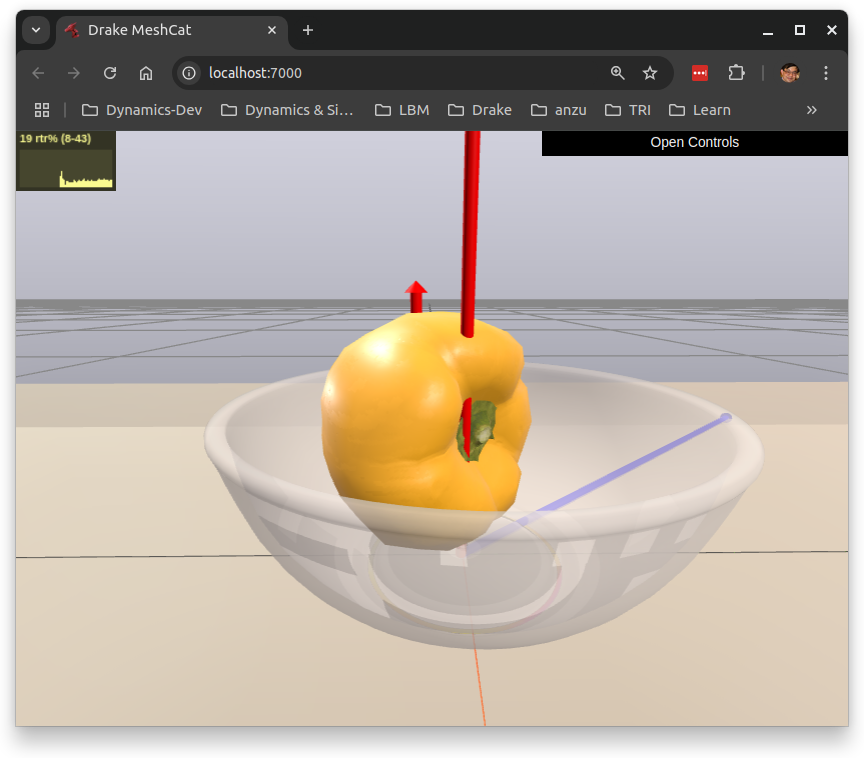

### Draw collision meshes of the three objects

In [7]:
meshcat.SetProperty("illustration", "visible", False)
meshcat.SetProperty("contact_forces",  "visible", False)
meshcat.SetProperty("proximity", "visible", False)
meshcat.SetProperty("/Grid", "visible", False)
meshcat.SetProperty("/Axes", "visible", False)

scene_graph = diagram.GetSubsystemByName("scene_graph")
inspector = scene_graph.model_inspector()
query_object = scene_graph.get_query_output_port().Eval(
    scene_graph.GetMyContextFromRoot(simulator.get_context()))

all_ids = inspector.GetAllGeometryIds()
for id in all_ids:
  if inspector.GetName(id) == "yellow_bell_pepper_no_stem::collision" :
    pepper_id = id
  if inspector.GetName(id) == "bowl::collision" :
    bowl_id = id
  if inspector.GetName(id) == "table_top::collision" :
    table_id = id
    
    
pepper_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(pepper_id))
print(f"pepper_mesh.num_vertices() = {pepper_mesh.num_vertices()}\n")

bowl_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(bowl_id))
print(f"bowl_mesh.num_vertices() = {bowl_mesh.num_vertices()}\n")

table_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(table_id))
print(f"table_mesh.num_vertices() = {table_mesh.num_vertices()}\n")

def DrawCollisionMeshInOneColorWithBlackEdges(name, id, mesh, surface_rgba):
  meshcat.SetTransform(f"{name}", query_object.GetPoseInWorld(id))
  meshcat.SetObject(f"{name}/shade", mesh, rgba = surface_rgba,
                    wireframe=False)
  meshcat.SetObject(f"{name}/wireframe", mesh, rgba=Rgba(0, 0, 0, 1),
                    wireframe=True, wireframe_line_width=2.0)

DrawCollisionMeshInOneColorWithBlackEdges("BellPepperMesh", pepper_id, pepper_mesh, Rgba(0.8, 0.8, 0, 0.5))
DrawCollisionMeshInOneColorWithBlackEdges("BowlMesh", bowl_id, bowl_mesh, Rgba(1, 1, 1, 1))
DrawCollisionMeshInOneColorWithBlackEdges("TableMesh", table_id, table_mesh, Rgba(0.9, 0.8, 0.7, 1))

pepper_mesh.num_vertices() = 486

bowl_mesh.num_vertices() = 3957

table_mesh.num_vertices() = 8



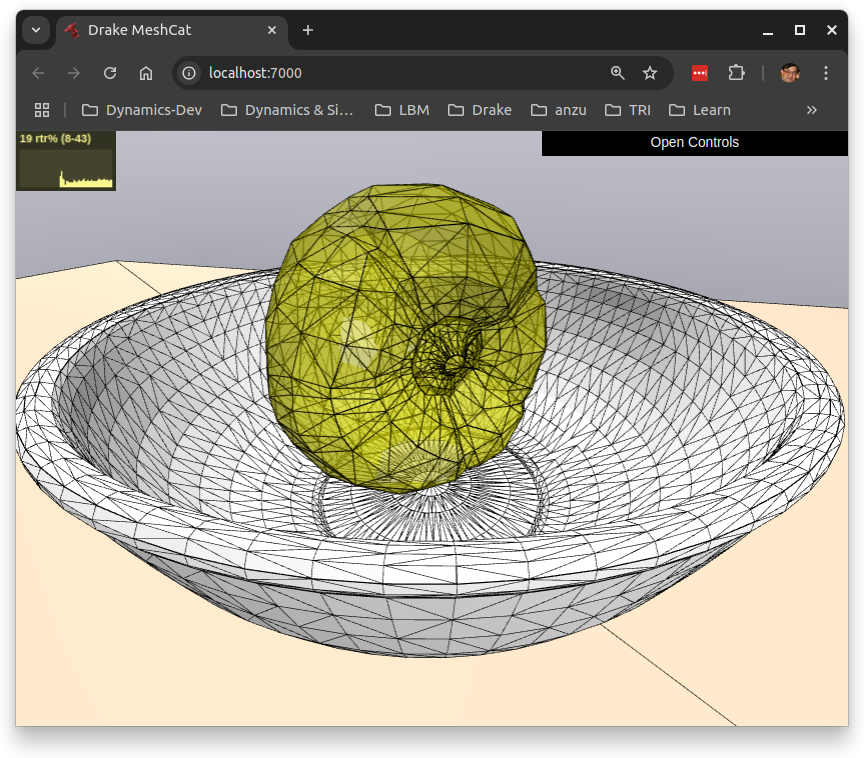

# Future Work for New Contact Patches

### Call ComputeContactVolumes()

Only bowl-pepper contact is supported because the table is a geometry::Box shape.

In [8]:
contact_volumes = query_object.ComputeContactVolumes()

In [9]:
print(f"Number of contact volume = {len(contact_volumes)}")
print()

def PrintContactSurface(s, inspector):
  print(f"id_M()={s.id_M()}")
  print(f"id_N()={s.id_N()}")
  print(f"inspector.GetName(id_M())={inspector.GetName(s.id_M())}")
  print(f"inspector.GetName(id_N())={inspector.GetName(s.id_N())}")
  print(f"num_faces()={s.num_faces()}")  
  print(f"num_vertices()={s.num_vertices()}")  
  print(f"total_area()={s.total_area()}")  
  print(f"centroid()={s.centroid()}")  
  print(f"is_triangle()={s.is_triangle()}")  
  print(f"representation()={s.representation()}")  
  print(f"HasGradE_M()={s.HasGradE_M()}")  
  print(f"HasGradE_N()={s.HasGradE_N()}")
  print(f"HasCentroidalValue()={s.HasCentroidalValue()}")  
  print()  

print("contact_volumes[0][0]:")
PrintContactSurface(contact_volumes[0][0], inspector)

print("contact_volumes[0][1]:")
PrintContactSurface(contact_volumes[0][1], inspector)

Number of contact volume = 1

contact_volumes[0][0]:
id_M()=<GeometryId value=20>
id_N()=<GeometryId value=27>
inspector.GetName(id_M())=yellow_bell_pepper_no_stem::collision
inspector.GetName(id_N())=bowl::collision
num_faces()=1905
num_vertices()=6677
total_area()=0.0008903220653964034
centroid()=[-0.01751087 -0.01850844  0.01282305]
is_triangle()=False
representation()=HydroelasticContactRepresentation.kPolygon
HasGradE_M()=False
HasGradE_N()=True
HasCentroidalValue()=True

contact_volumes[0][1]:
id_M()=<GeometryId value=20>
id_N()=<GeometryId value=27>
inspector.GetName(id_M())=yellow_bell_pepper_no_stem::collision
inspector.GetName(id_N())=bowl::collision
num_faces()=527
num_vertices()=1925
total_area()=0.0008478406982426445
centroid()=[-0.01702638 -0.01805242  0.01349744]
is_triangle()=False
representation()=HydroelasticContactRepresentation.kPolygon
HasGradE_M()=True
HasGradE_N()=False
HasCentroidalValue()=True



### We can't draw polygonal meshes, so we triangulate the polygons around their centroids.

In [10]:
def BoundaryNameOfContactSurface(s, inspector):
  name_M = inspector.GetName(s.id_M())
  name_N = inspector.GetName(s.id_N())  
  if s.HasGradE_M() and not s.HasGradE_N():
    mesh_name = f"BoundaryOf_{name_N}_IN_{name_M}"
  if not s.HasGradE_M() and s.HasGradE_N():
    mesh_name = f"BoundaryOf_{name_M}_IN_{name_N}"
  if s.HasGradE_M() and s.HasGradE_N():
    mesh_name = f"Between_{name_M}_and_{name_N}"
  return mesh_name  

def DrawTriangleMesh(name, mesh, rgba):
  meshcat.SetObject(f"{name}/shade", mesh, rgba = rgba, wireframe=False,
                               wireframe_line_width=3.0)
  meshcat.SetObject(f"{name}/wireframe", mesh, rgba = Rgba(0, 0, 0, 1), wireframe=True,
                               wireframe_line_width=3.0)

def TriangleMeshFromContactSurface(s):
  if s.is_triangle():
    triangle_mesh = s.tri_mesh_W()
  else:  
    poly_mesh = s.poly_mesh_W()
    triangle_mesh = _MakeTriangleFromPolygonMeshWithCentroids(poly_mesh)
  return triangle_mesh  
    
    
def DrawContactSurface(s, rgba, inspector):
  mesh_name = BoundaryNameOfContactSurface(s, inspector)  
  print(f"Draw {mesh_name}")
  DrawTriangleMesh(mesh_name, TriangleMeshFromContactSurface(s), rgba)
    
    
DrawContactSurface(contact_volumes[0][0] , Rgba(1, 1, 0, 1), inspector)
DrawContactSurface(contact_volumes[0][1] , Rgba(0.7, 0.7, 0.7, 1), inspector)

Draw BoundaryOf_yellow_bell_pepper_no_stem::collision_IN_bowl::collision
Draw BoundaryOf_bowl::collision_IN_yellow_bell_pepper_no_stem::collision


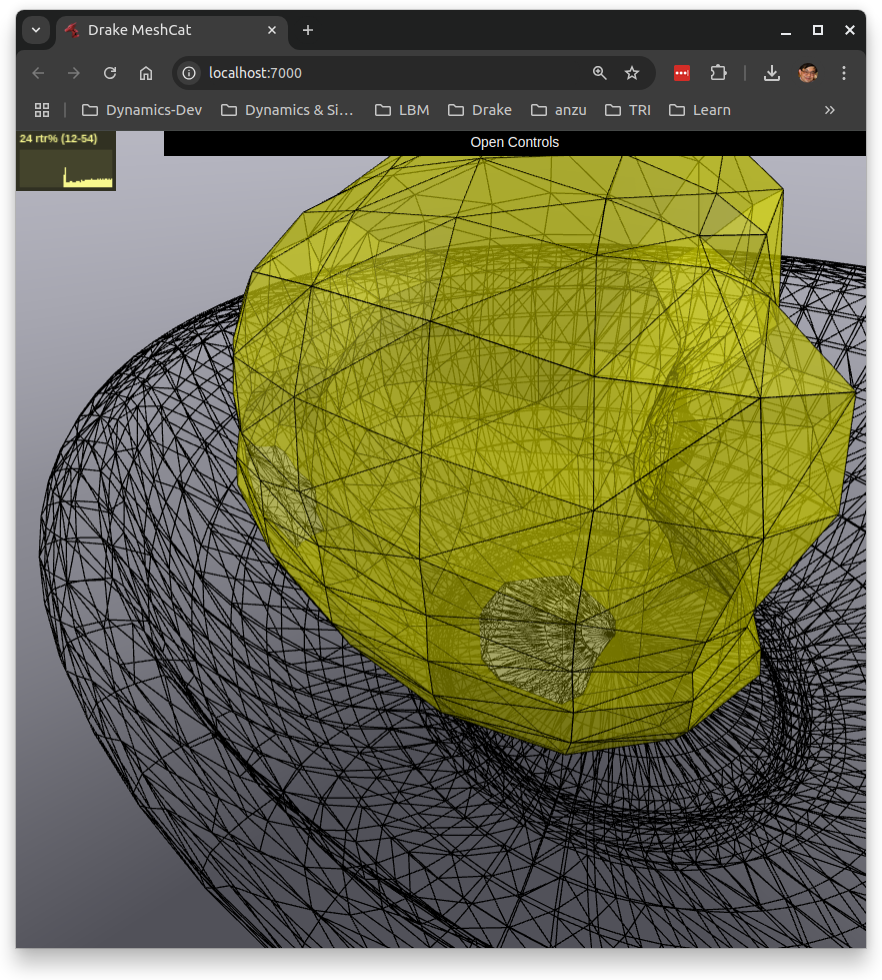

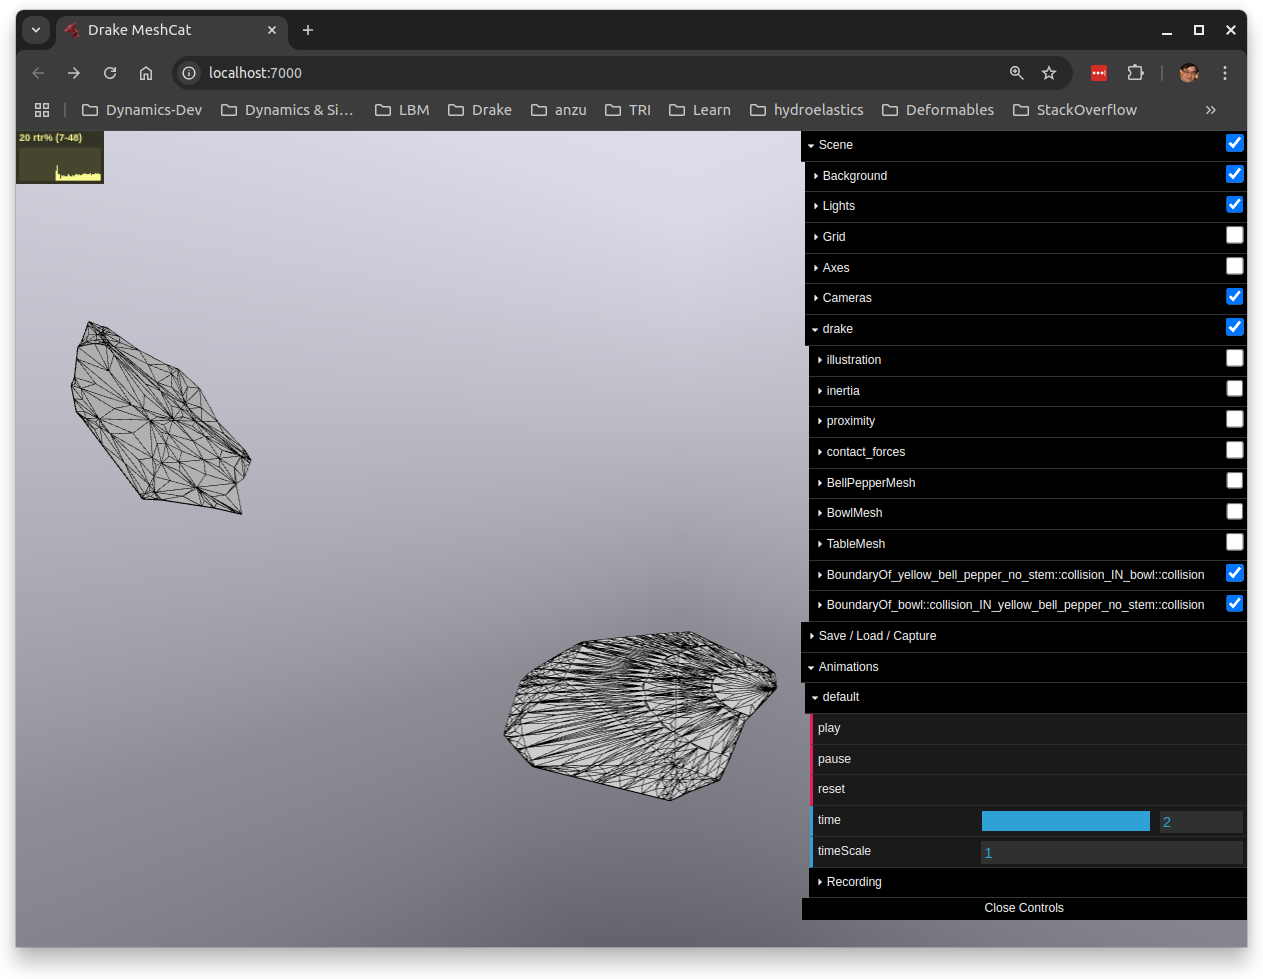

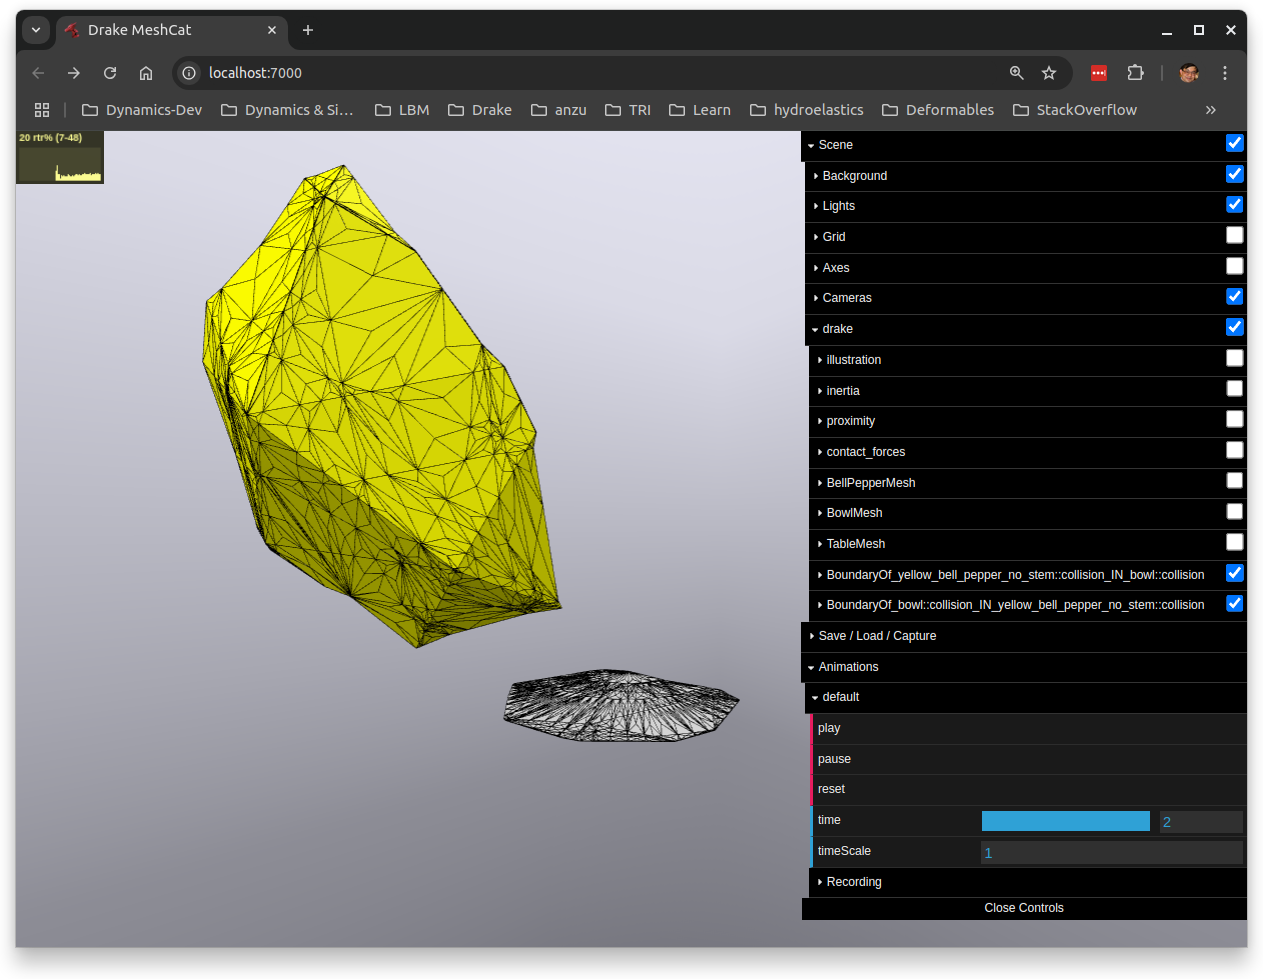

### Visualize face normals

In [11]:
# mesh_M can be a TriangleSurfaceMesh or a PolygonSurfaceMesh.
def DrawFaceNormal(name, mesh_M, rgba):
  # 1mm line  
  kNormalLength = 0.001  
  face_normals_M_list = [mesh_M.face_normal(f)
                         for f in range(mesh_M.num_elements())]
  face_normals_at_vertices_M = np.array(face_normals_M_list).transpose()
  centroids_of_faces_M_list = [mesh_M.element_centroid(f)
                               for f in range(mesh_M.num_elements())]  
  centroids_of_faces_M = np.array(centroids_of_faces_M_list).transpose()
  starts_M = centroids_of_faces_M
  ends_M = starts_M + kNormalLength * face_normals_at_vertices_M
  kRed = Rgba(r=1, g=0, b=0, a=1)
  meshcat.SetLineSegments(f"{name}/face_normals",
                          starts_M, ends_M, line_width=1, rgba=rgba)

def DrawContactFaceNormal(s, rgba, inspector):
  name = f"{BoundaryNameOfContactSurface(s, inspector)}/face_normal"
  print(f"Draw {name}")
  DrawFaceNormal(name, s.poly_mesh_W(), rgba)  

kDarkBrown = Rgba(0.39, 0.26, 0.12, 1)
DrawContactFaceNormal(contact_volumes[0][0], kDarkBrown, inspector)
kBlack = Rgba(0, 0, 0, 1)
DrawContactFaceNormal(contact_volumes[0][1], kBlack, inspector)

Draw BoundaryOf_yellow_bell_pepper_no_stem::collision_IN_bowl::collision/face_normal
Draw BoundaryOf_bowl::collision_IN_yellow_bell_pepper_no_stem::collision/face_normal


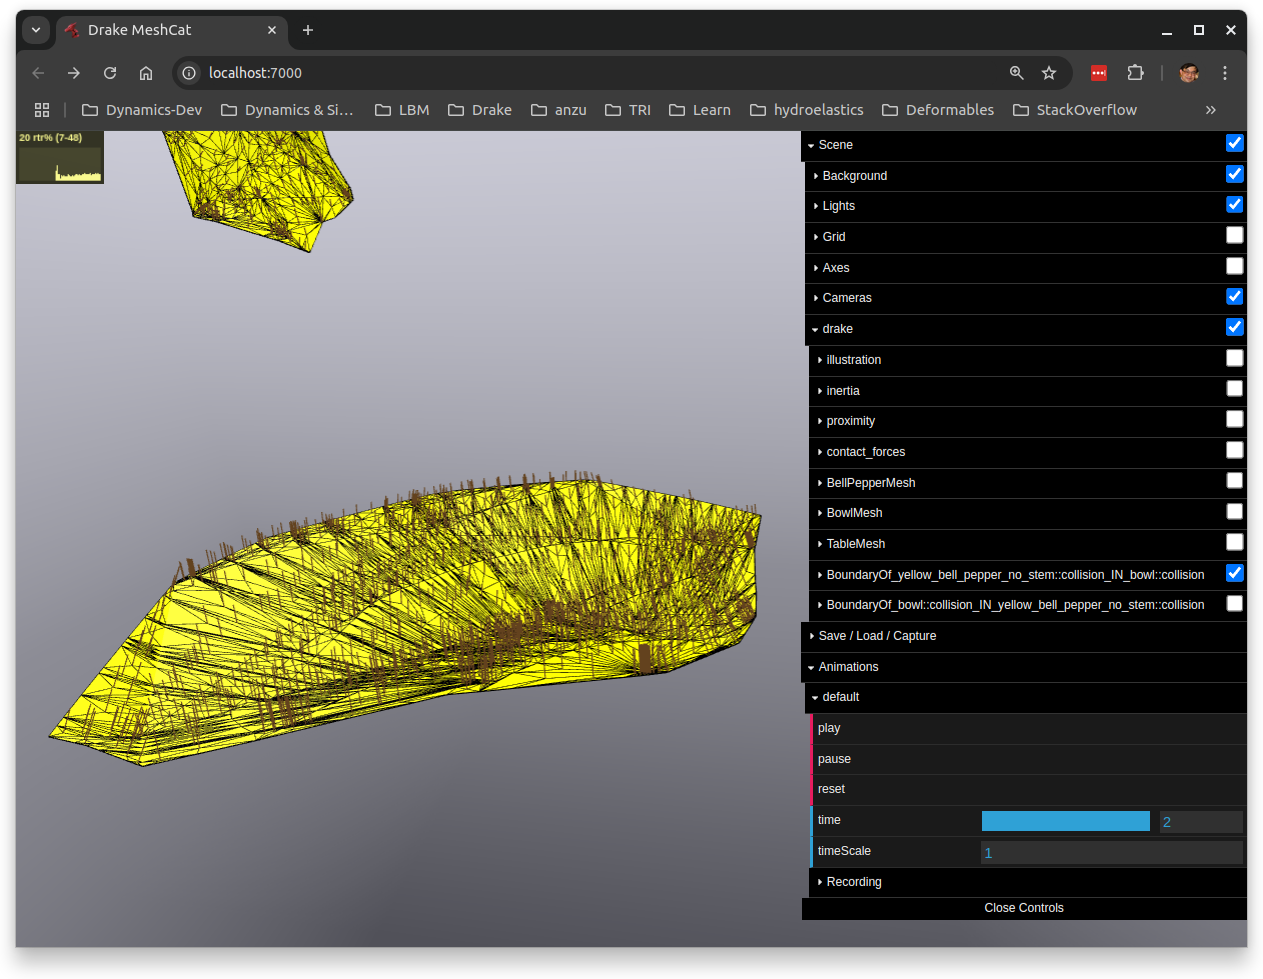

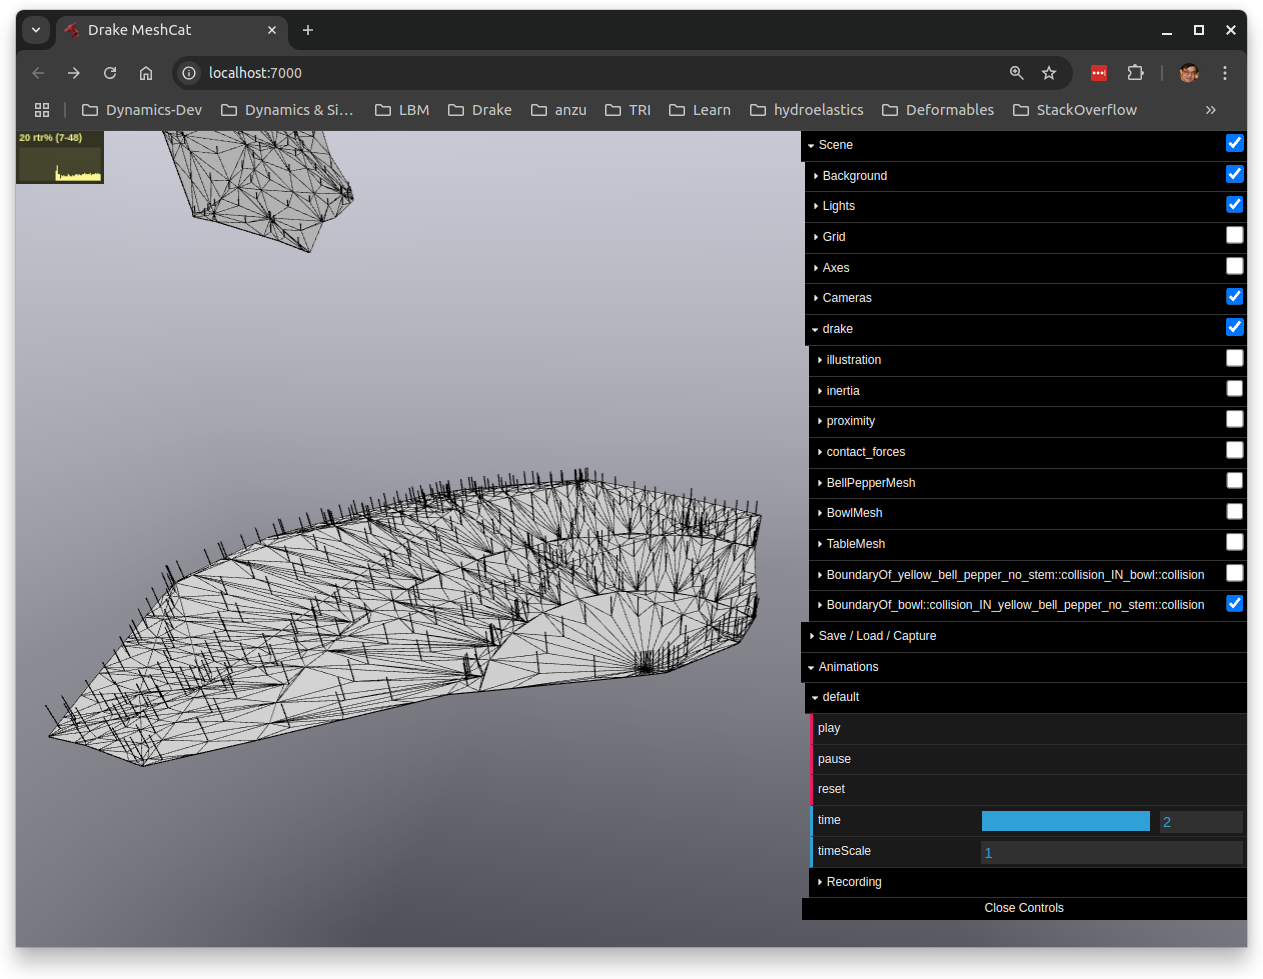

## Download simulation result into a html file for sharing

You can download the simulation result into a self-contained html file, allowing others to playback the simulated results without simulating. The following code prints the URL for downloading. Click on the printed URL to download.

In [ ]:
print(f"{meshcat.web_url()}/download")

## Further reading

* [Hydroelastic Contact User Guide](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

* Elandt, R., Drumwright, E., Sherman, M., & Ruina, A. (2019, November). A pressure field model for fast, robust approximation of net contact force and moment between nominally rigid objects. In 2019 IEEE/RSJ International Conference on Intelligent Robots and Systems(IROS) (pp. 8238-8245). IEEE. [link](https://arxiv.org/abs/1904.11433)

* Masterjohn, J., Guoy, D., Shepherd, J., & Castro, A. (2022). Velocity Level Approximation of Pressure Field Contact Patches. IEEE Robotics and Automation Letters 7, no. 4 (2022): 11593-11600. [link](https://arxiv.org/abs/2110.04157v2)

* Elandt, R. (2022, December). Pressure Field Contact. Dissertation. Cornell University. [link](https://ecommons.cornell.edu/handle/1813/112919)